## AI-Driven Cloud Resource Allocation using PPO

---

## Abstract

This project simulates dynamic resource allocation in a cloud environment using Reinforcement Learning (RL). We implement a custom simulation of VMs and fluctuating workloads where an RL agent (PPO) learns to optimally allocate CPU resources. Our goal is to minimize cost and inefficiencies while maintaining service quality. The agent is trained using the Proximal Policy Optimization (PPO) algorithm, and the results demonstrate effective learning compared to baseline random allocation.

---

## Objectives

- Simulate fluctuating workloads for multiple VMs.
- Train an RL agent to learn dynamic CPU allocation.
- Reduce resource wastage and cost.
- Compare AI allocation vs actual demand and visualize results.


In [ ]:
!pip install stable-baselines3
import gymnasium as gym
from gymnasium import spaces

!pip install torch torchvision torchaudio


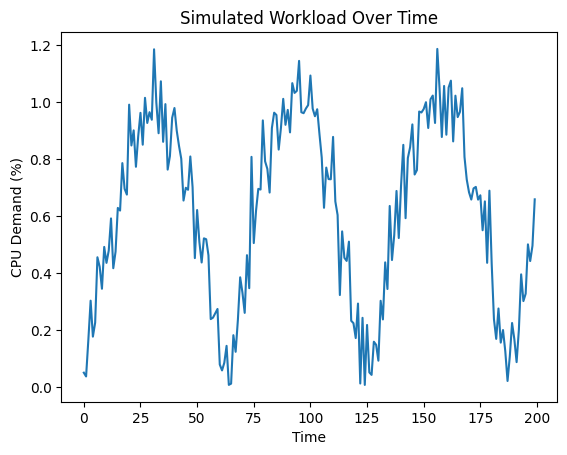

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate workload over time (CPU demand %)
np.random.seed(42)
timesteps = 200
workload = np.abs(np.sin(np.linspace(0, 10, timesteps)) + np.random.normal(0, 0.1, timesteps))

plt.plot(workload)
plt.title("Simulated Workload Over Time")
plt.xlabel("Time")
plt.ylabel("CPU Demand (%)")
plt.show()


This graph shows how the CPU demand changes over time in our simulated cloud environment. The demand goes up and down in a wave-like pattern, which represents real-world scenarios where usage is not constant. This fluctuation is important for testing how well our reinforcement learning agent can adapt to varying workloads. Understanding this pattern helps us analyze how responsive and flexible the agent needs to be in order to handle different demand levels effectively.



In [ ]:
import torch
import torch.nn as nn

# Create sequences
def create_sequences(data, window=10):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window_size = 10
X, y = create_sequences(workload, window_size)
X = torch.tensor(X).float().unsqueeze(-1)
y = torch.tensor(y).float().unsqueeze(-1)


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[-1])
        return out

model = LSTM()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(100):
    losses = []
    for i in range(len(X)):
        input_seq = X[i].unsqueeze(1)
        target = y[i]
        optimizer.zero_grad()
        output = model(input_seq)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {np.mean(losses):.4f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.0563
Epoch 10, Loss: 0.0277
Epoch 20, Loss: 0.0221
Epoch 30, Loss: 0.0201
Epoch 40, Loss: 0.0160
Epoch 50, Loss: 0.0149
Epoch 60, Loss: 0.0140
Epoch 70, Loss: 0.0131
Epoch 80, Loss: 0.0124
Epoch 90, Loss: 0.0117


In [ ]:
import gymnasium as gym
from gymnasium import spaces

class CloudEnv(gym.Env):
    def __init__(self):
        super(CloudEnv, self).__init__()
        self.max_cpu = 1.0
        self.state = np.array([0.5, 0.5])
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(2,), dtype=np.float32)
        self.step_idx = 0
        self.workload = workload
    def reset(self, seed=None, options=None):
       super().reset(seed=seed)
       self.step_idx = 0
       self.state = np.array([self.workload[self.step_idx], 0.5], dtype=np.float32)
       return self.state, {}

    def step(self, action):
       demand = self.workload[self.step_idx]
       alloc = np.clip(action[0], 0.0, 1.0)
       cost = alloc
       penalty = abs(alloc - demand)
       reward = - (cost + penalty)

       self.step_idx += 1
       done = self.step_idx >= len(self.workload)
       next_state = np.array([self.workload[self.step_idx % len(self.workload)], alloc], dtype=np.float32)
       self.state = next_state
       return next_state, reward, done, False, {}



In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

env = CloudEnv()
check_env(env)  #This still passes

# Train using PPO (supports continuous action spaces)
model_ppo = PPO("MlpPolicy", env, verbose=1)
model_ppo.learn(total_timesteps=90000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -165     |
| time/              |          |
|    fps             | 1392     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 200          |
|    ep_rew_mean          | -163         |
| time/                   |              |
|    fps                  | 909          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0052445144 |
|    clip_fraction        | 0.0316       |
|    clip_range           | 0.2          |
|    en

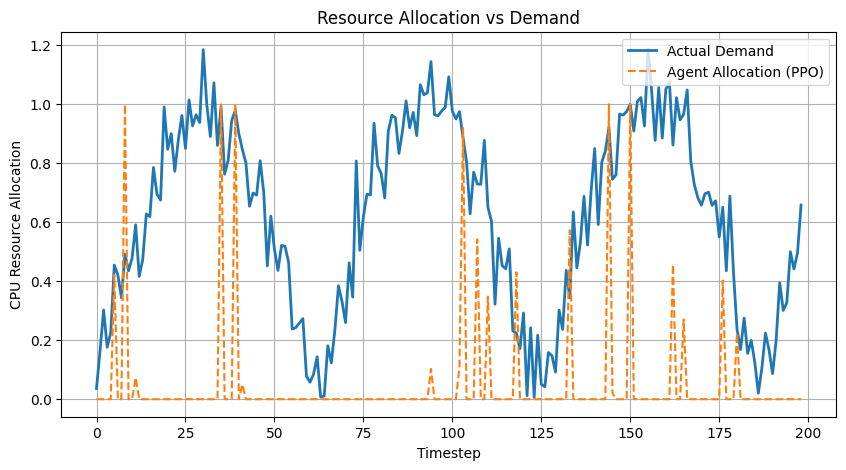

📊 Average Reward: -0.6296


In [ ]:
import matplotlib.pyplot as plt

# Reset environment to get initial state
state, _ = env.reset()
rewards = []
allocations = []
demands = []

for _ in range(len(env.workload) - 1):
    action, _ = model_ppo.predict(state)
    state, reward, done, truncated, _ = env.step(action)

    rewards.append(reward)
    allocations.append(action[0])
    demands.append(state[0])

    if done:
        break

# Plotting allocation vs actual demand
plt.figure(figsize=(10, 5))
plt.plot(demands, label='Actual Demand', linewidth=2)
plt.plot(allocations, label='Agent Allocation (PPO)', linestyle='--')
plt.xlabel("Timestep")
plt.ylabel("CPU Resource Allocation")
plt.title("Resource Allocation vs Demand")
plt.legend()
plt.grid(True)
plt.show()

# Print avg reward
print(f"📊 Average Reward: {np.mean(rewards):.4f}")


In this graph, we compare the actual CPU demand (blue line) with the CPU resources allocated by the PPO agent (orange dashed line). Ideally, the agent should allocate just enough resources to match the demand. If the orange line closely follows the blue line, it means the agent is learning and performing well. However, if there's a big gap between them, it shows under- or over-allocation. This graph helps us visually track how well the agent is optimizing resource usage.



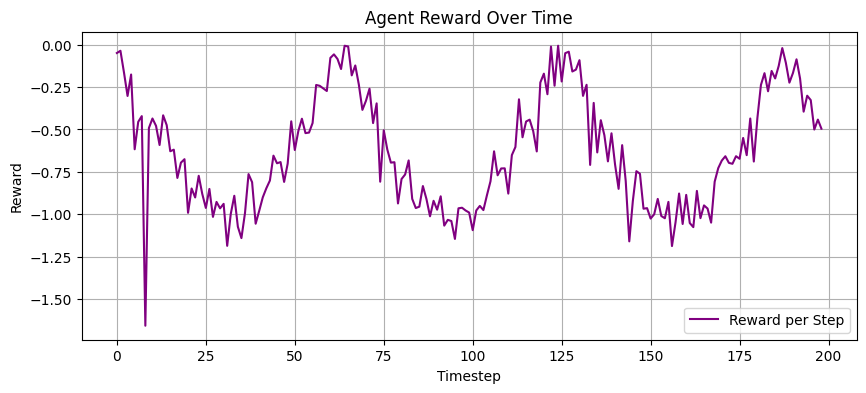

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(rewards, label="Reward per Step", color='purple')
plt.xlabel("Timestep")
plt.ylabel("Reward")
plt.title("Agent Reward Over Time")
plt.grid(True)
plt.legend()
plt.show()


This graph represents the agent's reward at each timestep. The reward depends on how close the allocation is to the actual demand — the smaller the error and the lower the cost, the better the reward. Early in the training, we can see more negative values, which is expected as the agent is still learning. Over time, if the rewards start improving or become more stable, it shows the agent is getting better at making decisions. It’s a direct measure of how well the agent is learning from its environment.



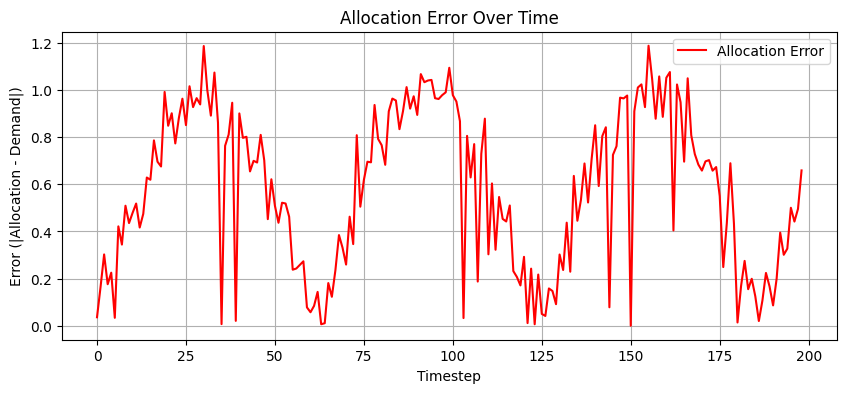

In [ ]:
errors = [abs(a - d) for a, d in zip(allocations, demands)]

plt.figure(figsize=(10, 4))
plt.plot(errors, label="Allocation Error", color='red')
plt.xlabel("Timestep")
plt.ylabel("Error (|Allocation - Demand|)")
plt.title("Allocation Error Over Time")
plt.grid(True)
plt.legend()
plt.show()


Here, we visualize the allocation error — the absolute difference between what the agent allocated and what was actually needed. The lower the error, the better. High spikes in this graph mean that the agent's allocation was far from ideal at those timesteps. This helps us spot weaknesses in the agent’s performance and understand if it's consistently improving or still struggling to match demand accurately.

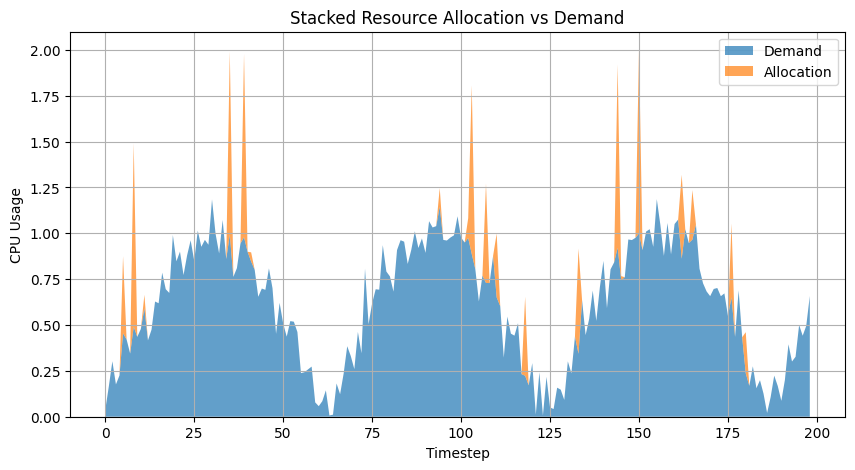

In [ ]:
plt.figure(figsize=(10, 5))
plt.stackplot(range(len(demands)), demands, allocations, labels=['Demand', 'Allocation'], alpha=0.7)
plt.xlabel("Timestep")
plt.ylabel("CPU Usage")
plt.title("Stacked Resource Allocation vs Demand")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


This stacked area chart combines both demand and allocation to give a more visual comparison. The blue area represents the CPU demand, while the orange part stacked on top shows how much the agent allocated. If the orange barely goes above the blue, it means the allocation was close and efficient. A lot of orange sticking out would mean over-allocation and wasted resources. This type of visualization makes it easier to see the overall resource usage and efficiency in one glance.

